# UFC Retirement Age - Modeling

## 1. Contents<a id='1._Contents'></a>
* [UFC Retirement Age - Modeling](#UFC_Retirement_Age_-_Modeling)
  * [1. Contents](#1._Contents)
  * [2. Sourcing and Loading](#2._Sourcing_and_Loading)
    * [2a. Import relevant libraries](#2a._Import_relevant_libraries)
    * [2b. Load previously preprocessed DataFrame](#2b._Load_previously_preprocessed_DataFrame)
    * [2c. Preliminary exploration of data](#2c._Preliminary_exploration_of_data)
  * [3. Additional Data Wrangling](#3._Additional_Data_Wrangling)
    * [3a. Bout columns](#3a._Bout_columns)
    * [3b. Isolating X and y columns](#3b._Isolating_X_and_y_columns)
    * [3c. Removing null columns](#3c._Removing_null_columns)
    * [3d. New fight performance column](#3d._New_fight_performance_column)
    * [3e. Remove outlier row](#3e._Remove_outlier_row)
  * [4. Modeling](#4._Modeling)
    * [4a. Finding best features for linear regression model](#4a._Finding_best_features_for_linear_regression_model)
    * [4b. Finding best features for random forest regressor](#4b._Finding_best_features_for_random_forest_regressor)
    * [4c. Choosing best model](#4c._Choosing_best_model)
    * [4d. Linear regression model analysis](#4d._Linear_regression_model_analysis)
  * [5. Conclusion](#5._Conclusion)

## 2. Sourcing and Loading <a id='2._Sourcing_and_Loading'></a>

**2a. Import relevant libraries** <a id='2a._Import_relevant_libraries'></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle as kg
import pandas as pd
import missingno as msno
import statsmodels.api as sm
import scipy.stats
from matplotlib.lines import Line2D
from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, \
plot_roc_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, preprocessing
from zipfile import ZipFile
from scipy import stats
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from numpy.random import seed
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

**2b. Load previously preprocessed DataFrame** <a id='2b._Load_previously_preprocessed_DataFrame'></a>

In [2]:
df = pd.read_csv('df.csv', index_col=0)
df.head()

,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,...,weight_class_Middleweight,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch
0,2020-10-03,Holly Holm,-125,1,0,0,1,0,2.75,0.35,...,0,0,1,0,0,0,0,0,1,0
1,2020-10-03,Irene Aldana,103,0,0,0,2,0,6.16,0.38,...,0,0,1,0,0,0,0,1,0,0
2,2020-10-03,Yorgan De Castro,-265,0,0,1,0,0,2.19,0.41,...,0,0,0,0,0,0,1,1,0,0
3,2020-10-03,Carlos Felipe,205,1,0,1,0,0,2.93,0.36,...,0,0,0,0,0,0,1,1,0,0
4,2020-10-03,Germaine de Randamie,-150,1,0,1,0,0,2.72,0.47,...,0,0,1,0,0,0,0,1,0,0


**2c. Preliminary exploration of data** <a id='2c._Preliminary_exploration_of_data'></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 0 to 8815
Columns: 103 entries, date to Stance_Switch
dtypes: float64(29), int64(72), object(2)
memory usage: 7.0+ MB


In [4]:
df.shape

(8816, 103)

In [5]:
df.columns

Index(['date', 'fighter', 'odds', 'Winner', 'title_bout',
       'current_lose_streak', 'current_win_streak', 'draw',
       'avg_SIG_STR_landed', 'avg_SIG_STR_pct',
       ...
       'weight_class_Middleweight', 'weight_class_Welterweight',
       'weight_class_Women's Bantamweight',
       'weight_class_Women's Featherweight', 'weight_class_Women's Flyweight',
       'weight_class_Women's Strawweight', 'gender_MALE', 'Stance_Orthodox',
       'Stance_Southpaw', 'Stance_Switch'],
      dtype='object', length=103)

# 3. Additional Data Wrangling <a id='3._Additional_Data_Wrangling'></a>

**3a. Bout columns** <a id='3a._Bout_columns'></a>

Many of the bout columns provide stats on the entire bout, but since some fights end in the first round and others can go all 5 rounds, these columns would be much more helpful to us if they gave us an average over the seconds spent in the fight. 

In [6]:
bout_data = [column for column in df.columns if column.endswith(('d_bout','s_bout','v_bout'))]
bout_data

['kd_bout',
 'sig_str_landed_bout',
 'sig_str_attempted_bout',
 'tot_str_landed_bout',
 'tot_str_attempted_bout',
 'td_landed_bout',
 'td_attempted_bout',
 'sub_attempts_bout',
 'pass_bout',
 'rev_bout']

In [7]:
for column in df[bout_data].columns:
    df[column] = df[column] / df['total_fight_time_secs']
    
df[bout_data].describe()

,kd_bout,sig_str_landed_bout,sig_str_attempted_bout,tot_str_landed_bout,tot_str_attempted_bout,td_landed_bout,td_attempted_bout,sub_attempts_bout,pass_bout,rev_bout
count,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000,5544.000000
mean,0.001265,0.062168,0.137246,0.086543,0.165105,0.001710,0.004524,0.000890,0.001871,0.000218
std,0.006181,0.054308,0.092434,0.062350,0.094618,0.002944,0.005811,0.002817,0.003806,0.001217
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031111,0.076706,0.048889,0.103433,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.051111,0.121111,0.074266,0.151111,0.000000,0.002661,0.000000,0.000000,0.000000
75%,0.000000,0.077778,0.176287,0.107778,0.204372,0.002222,0.006667,0.000000,0.002222,0.000000
max,0.142857,0.857143,1.428571,0.857143,1.428571,0.041667,0.068966,0.071429,0.058824,0.071429


In [8]:
secs_data = [column.replace('_bout', '_per_sec') for column in bout_data]
secs_data

['kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

In [9]:
for bout_column, secs_column in zip(bout_data, secs_data):
    df.rename({bout_column: secs_column}, axis=1, inplace=True)

df[secs_data].tail()

,kd_per_sec,sig_str_landed_per_sec,sig_str_attempted_per_sec,tot_str_landed_per_sec,tot_str_attempted_per_sec,td_landed_per_sec,td_attempted_per_sec,sub_attempts_per_sec,pass_per_sec,rev_per_sec
8811,0.0,0.042553,0.127660,0.042553,0.127660,0.000000,0.042553,0.000000,0.000000,0.000000
8812,0.0,0.043333,0.084444,0.100000,0.145556,0.006667,0.011111,0.000000,0.006667,0.000000
8813,0.0,0.018889,0.068889,0.034444,0.084444,0.000000,0.000000,0.000000,0.000000,0.000000
8814,0.0,0.030000,0.090000,0.057778,0.118889,0.002222,0.003333,0.001111,0.001111,0.001111
8815,0.0,0.077778,0.161111,0.144444,0.228889,0.003333,0.006667,0.001111,0.006667,0.001111


**3b. Isolating X and y columns** <a id='3b._Isolating_X_and_y_columns'></a>

`age` is going to be our dependent variable, while our independent variables are going to be based on fight performance.

In [10]:
fight_perf = ['Winner','finish'] + secs_data
fight_perf

['Winner',
 'finish',
 'kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

**3c. Removing null columns** <a id='3c._Removing_null_columns'></a>

In [11]:
df_no_null = df[df[fight_perf].notnull().all(axis=1)]
df_no_null[fight_perf].isnull().sum()

Winner                       0
finish                       0
kd_per_sec                   0
sig_str_landed_per_sec       0
sig_str_attempted_per_sec    0
tot_str_landed_per_sec       0
tot_str_attempted_per_sec    0
td_landed_per_sec            0
td_attempted_per_sec         0
sub_attempts_per_sec         0
pass_per_sec                 0
rev_per_sec                  0
dtype: int64

In [12]:
df_no_null.reset_index(inplace=True)

**3d. New fight performance column** <a id='3d._New_fight_performance_column'></a>

Since some fighters are strikers while some are wrestlers, most fights will have a disproportionate amount of either strikes or takedowns attempted each fight. These stats would be a lot more helpful to us if they were combined based on their weight. For example, throwing out a few insignificant strikes is a much smaller action than attempting a takedown. So, each metric of fight performance will be weighted based on `tot_str_attempted_per_sec` and combined into one final column that summarizes all of them: `action_per_sec`.

In [13]:
X = df_no_null[fight_perf]
y = df_no_null['age']

X.mean().sort_values(ascending=False)

Winner                       0.500000
tot_str_attempted_per_sec    0.165105
sig_str_attempted_per_sec    0.137246
tot_str_landed_per_sec       0.086543
sig_str_landed_per_sec       0.062168
td_attempted_per_sec         0.004524
pass_per_sec                 0.001871
td_landed_per_sec            0.001710
kd_per_sec                   0.001265
sub_attempts_per_sec         0.000890
rev_per_sec                  0.000218
finish                       0.000000
dtype: float64

In [14]:
per_sec = [column for column in df_no_null[fight_perf].columns if column.endswith('per_sec')]
per_sec

['kd_per_sec',
 'sig_str_landed_per_sec',
 'sig_str_attempted_per_sec',
 'tot_str_landed_per_sec',
 'tot_str_attempted_per_sec',
 'td_landed_per_sec',
 'td_attempted_per_sec',
 'sub_attempts_per_sec',
 'pass_per_sec',
 'rev_per_sec']

In [15]:
for i, row in df_no_null.iterrows():
    df_no_null.loc[i, 'action_per_sec'] = 0
    for column in per_sec:
        if column == 'tot_str_attempted_per_sec':
            df_no_null.loc[i, 'action_per_sec'] += row['tot_str_attempted_per_sec']
        else:
            df_no_null.loc[i, 'action_per_sec'] += ((df_no_null['tot_str_attempted_per_sec'].mean()/df_no_null[column].mean()) 
                                             * row[column])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
df_no_null[fight_perf+['action_per_sec']].head()

,Winner,finish,kd_per_sec,sig_str_landed_per_sec,sig_str_attempted_per_sec,tot_str_landed_per_sec,tot_str_attempted_per_sec,td_landed_per_sec,td_attempted_per_sec,sub_attempts_per_sec,pass_per_sec,rev_per_sec,action_per_sec
0,1,3.0,0.000000,0.062667,0.100667,0.175333,0.227333,0.003333,0.010667,0.0,0.001333,0.0,1.678158
1,0,-3.0,0.000000,0.044000,0.083333,0.058667,0.104667,0.000000,0.000000,0.0,0.000000,0.0,0.433694
2,1,1.0,0.000000,0.091333,0.181333,0.092667,0.183333,0.002000,0.006000,0.0,0.000000,0.0,1.232900
3,0,-1.0,0.000000,0.068000,0.178667,0.074000,0.184667,0.000000,0.000000,0.0,0.000000,0.0,0.721371
4,1,4.0,0.000712,0.138177,0.220085,0.183761,0.267806,0.000712,0.001425,0.0,0.000712,0.0,1.526701


**3e. Remove outlier row** <a id='3e._Remove_outlier_row'></a>

In [17]:
df_no_null[df_no_null['action_per_sec'] > 60]

,index,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,...,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch,action_per_sec
3144,5250,2015-02-28,Ronda Rousey,-660,1,1,0,4,0,18.75,...,0,1,0,0,0,0,1,0,0,67.321805


In [18]:
df_no_null.drop(index=3144, inplace=True)
df_no_null[df_no_null['action_per_sec'] > 60]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,index,date,fighter,odds,Winner,title_bout,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,...,weight_class_Welterweight,weight_class_Women's Bantamweight,weight_class_Women's Featherweight,weight_class_Women's Flyweight,weight_class_Women's Strawweight,gender_MALE,Stance_Orthodox,Stance_Southpaw,Stance_Switch,action_per_sec


# 4. Modeling <a id='4._Modeling'></a>

**4a. Finding best features for linear regression model** <a id='4a._Finding_best_features_for_linear_regression_model'></a>

In [19]:
X = df_no_null[['Winner', 'finish', 'action_per_sec']]
y = df_no_null['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [21]:
from sklearn.model_selection import GridSearchCV

k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selectkbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x000001EED0B583A8>)),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='depreca

In [22]:
lr_grid_cv.best_params_

{'selectkbest__k': 3}

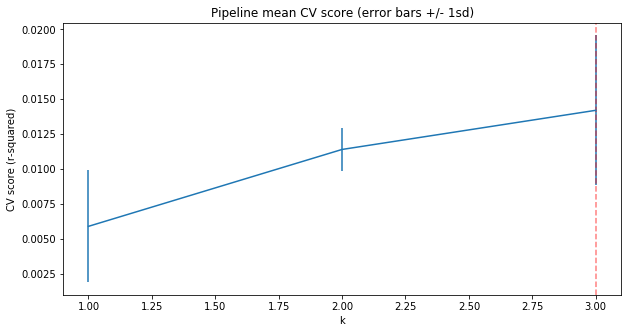

In [23]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [24]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
best_features = pd.Series(coefs, index=features).sort_values(ascending=False)
best_features

Winner            0.405331
action_per_sec   -0.279592
finish           -0.708890
dtype: float64

In [25]:
lin_features = [feature for feature in best_features.index]
lin_features

['Winner', 'action_per_sec', 'finish']

**4b. Finding best features for random forest regressor** <a id='4b._Finding_best_features_for_random_forest_regressor'></a>

In [26]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [27]:
from sklearn.ensemble import RandomForestRegressor

RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}

rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

rf_grid_cv.fit(X_train, y_train)

rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 297,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [28]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.32639605, -0.36404937, -0.27781097, -0.30425918, -0.35332907])

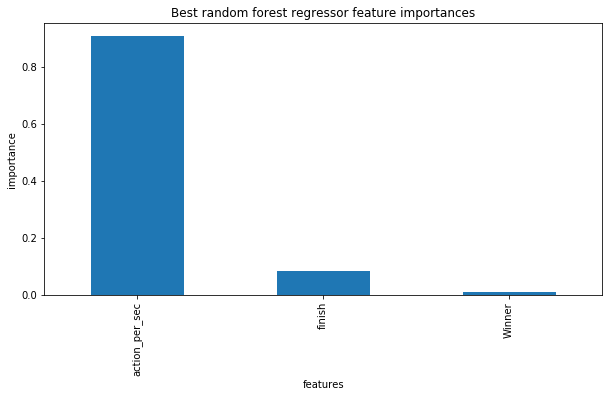

In [29]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [30]:
rf_features = ['action_per_sec']
rf_features

['action_per_sec']

**4c. Choosing best model** <a id='4c._Choosing_best_model'></a>

In [31]:
X = df_no_null[lin_features]
y = df_no_null['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(3.190837849178593, 0.05554077865090612)

In [32]:
X = df_no_null['action_per_sec']

rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(3.665590888581896, 0.08387041751096803)

Based on a scoring of mean absolute error, linear regression seems to be the superior model here.

**4d. Linear regression model analysis** <a id='4d._Linear_regression_model_analysis'></a>

In [33]:
X = df_no_null[lin_features]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = sm.OLS(y_train, X_train)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.84
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           9.04e-13
Time:                        17:52:49   Log-Likelihood:                -12445.
No. Observations:                4434   AIC:                         2.490e+04
Df Residuals:                    4430   BIC:                         2.492e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             29.8811      0.251    119.229      0.000      29.390      30.372
Winner             0.2733      0.449      0.608      0.543      -0.608       1.154
action_per_sec    -0.2163      0.044     -4.882      0.000      -0.303      -0.129
finish            -0.1014      0.067     -1.508      0.132      -0.233       0.030
==============================================================================
Omnibus:                       70.022   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.987
Skew:                           0.312   Prob(JB):                     1.42e-16
Kurtosis:                       3.072   Cond. No.                         30.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With such a weak R-squared despite finding the optimal features and best model for our data, we are hard-pressed to find any sort of correlation between age and fight performance. 

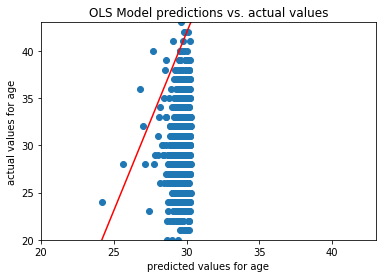

In [34]:
pred = model.fit().predict(X_test)

_ = plt.scatter(pred, y_test)
_ = plt.plot(plt.xlim(), plt.ylim(), color='red')
_ = plt.xlabel('predicted values for age')
_ = plt.ylabel('actual values for age')
_ = plt.title('OLS Model predictions vs. actual values')
_ = plt.xlim(min(y_test), max(y_test))
_ = plt.ylim(min(y_test), max(y_test))

A plot of predicted values vs. actual values in our test set shows that the predicted values is a lot more limited than the actual values.

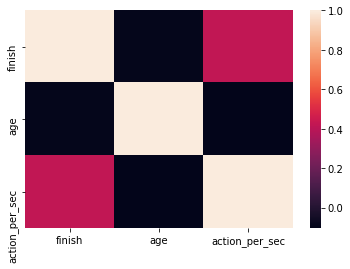

In [35]:
_ = sns.heatmap(df_no_null[['finish','age','action_per_sec']].corr())

A further visualization of the correlation between our dependent and independent variables shows us that there seems to be no correlation at all between `age` and `finish` or `action_per_sec`.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.141
Accuracy score (validation): 0.080

Learning rate:  0.1
Accuracy score (training): 0.153
Accuracy score (validation): 0.078

Learning rate:  0.25
Accuracy score (training): 0.174
Accuracy score (validation): 0.096

Learning rate:  0.5
Accuracy score (training): 0.158
Accuracy score (validation): 0.090

Learning rate:  0.75
Accuracy score (training): 0.029
Accuracy score (validation): 0.029

Learning rate:  1
Accuracy score (training): 0.021
Accuracy score (validation): 0.028



# 5. Conclusion <a id='5._Conclusion'></a>

Despite our best efforts to fit a model to the data, using Grid Search and Cross-Validation, we were unsuccessful in our efforts to predict a fighter's age based on their fight performance. Whether a fighter wins or loses a fight, or how active they are in a bout, these factors have at most a weak correlation with age. Therefore, we can conclude that there is no universal age at which the average UFC fighter should retire. Instead, that is a case-by-case decision that fighters and their teams must decide on their own. 